### 1. DEMO

In [293]:
import seaborn as sns
import torch
from torch.optim import Adam
import random
import numpy as np
from pylab import subplot
import matplotlib.pyplot as plt

seed = 10
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

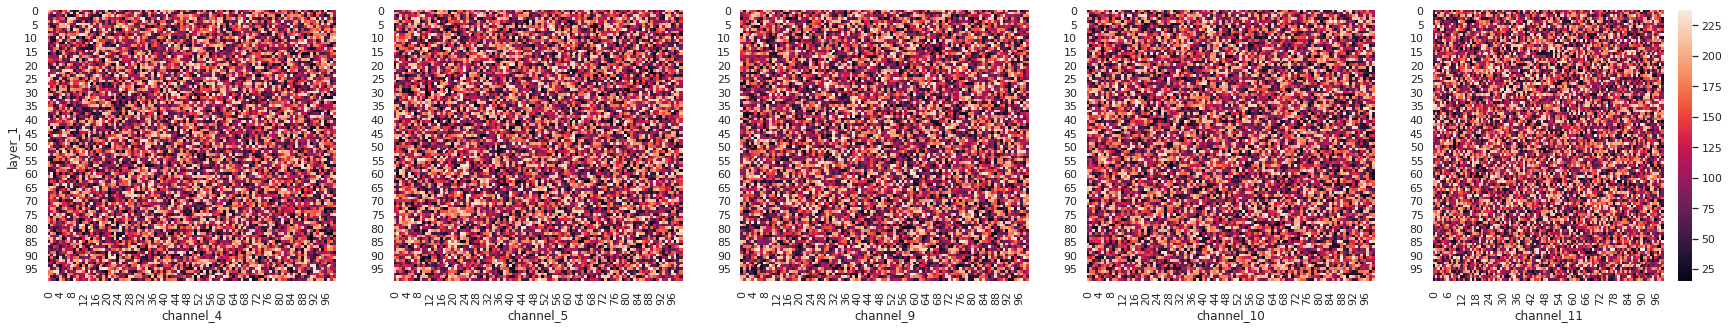

In [294]:
sns.set(style='darkgrid', rc={"figure.figsize": (30, 5)})
rows = 1
cols = 5

x = torch.rand(1,15, 100, 100)

plt.figure()

def convert_rgb(data:torch.tensor):
    res = (data - data.mean())/data.std() 
    res = (res * 64 + 128).int().clamp(0, 255)
    return res

seed = 5
random.seed(seed)
channels_idx = np.sort(random.sample(range(x.shape[1]), cols)) \
                if x.shape[1] > cols else range(x.shape[1])
for idx, c in enumerate(channels_idx):
    feature = x[0,c,...]
    norm_feature = convert_rgb(feature)

    subplot(1, cols, idx + 1)
    cbar_ = True if idx == cols - 1 else False
    ax = sns.heatmap(data = norm_feature,  cbar=cbar_)
    ax.set_xlabel("channel_{}".format(c))
    if idx == 0:
        ax.set_ylabel("layer_{}".format(1))
plt.show()
#plt.savefig('test.jpg')

### 2. Featuremap Visualization

In [296]:
import argparse
import copy
import os, sys
import os.path as osp
import time
import cv2
import numpy as np
import mmcv
import torch
from mmcv import Config, DictAction
from mmcv.runner import checkpoint, init_dist
from mmcv.runner import load_checkpoint
from argparse import ArgumentParser, Namespace

from lbitcls import __version__
from lbitcls import models
from lbitcls.datasets import build_dataset
from lbitcls.utils import collect_env, get_root_logger
from lbitcls.models import build_classifier
from lbitcls.apis import set_random_seed, train_classifier
from lbitcls.datasets.pipelines import Resize, CenterCrop

from thirdparty.mtransformer import build_mtransformer
from functools import partial
from thirdparty.model_analysis_tool.MultiModelCmp import MultiModelCmp
from lbitcls.apis import init_model, inference_model


def infer(model, img):
    out= model(img, return_loss=False)
    return out

In [297]:
img = '1260,3f000afab0a06'

configs = ['../../thirdparty/configs/benchmark/config7_mobilev2_float_2m_b64_coslr.py',
           '../../thirdparty/configs/LSQDPlusBack/config20_mobilenetv2_lsqdplus_int4_addoffset_lr4x_selfback_4m.py']
checkpoints = ['../../thirdparty/modelzoo/MobileNetV2.pth',
               '../../work_dirs/LSQDPlusBack/config20_mobilenetv2_lsqdplus_int4_addoffset_lr4x_selfback_4m_new/latest.pth']
extra_names = ['MBV2-fp32', 
               'MBV2-int4']

save_path = 'features.jpg'
device = 'cpu'

In [298]:
models = []
for idx, config in enumerate(configs):
    models.append(init_model(config, checkpoints[idx], device = device))

Use load_from_local loader
Use load_from_local loader


In [320]:
from functools import partial
from collections import OrderedDict
import torch.nn as nn
from thirdparty.model_analysis_tool.MultiModelCmp import OneModelDeploy
try:
    from thirdparty.mtransformer.DSQ.DSQConv import DSQConv
    from thirdparty.mtransformer.APOT.APOTLayers import APOTQuantConv2d
    from thirdparty.mtransformer.LSQ.LSQConv import LSQConv2d
    from thirdparty.mtransformer.LSQPlus import LSQDPlusConv2d
except ImportError:
    raise ImportError("Please import ALL Qunat layer!!!!")

QUATN_LAYERS = (DSQConv, LSQConv2d, APOTQuantConv2d, LSQDPlusConv2d)
from multiprocessing import Pool
import multiprocessing as mp

class OneModelDeployV2(OneModelDeploy):
        
    def hook_fn(self, module, input, output, name, is_quant = False):
        r""" Forward  Hooks 
        Args: 
            model:  nn.model
            input:  Module input tensor
            output: Module output tensor
            name:   Module layer name
        Action:        
            save nn.Conve and nn.Linear Input Tensor
            save BatchNorm and Relu layer output 
        """
        #if name not in ["conv1", "bn1", "relu", "maxpool"]:
        if True:
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                self._layers_input_dict[name] = input[0].cpu().detach()
            elif isinstance(module, nn.ReLU):
                self._layers_output_dict[name] = output.cpu().detach()
            elif isinstance(module, nn.BatchNorm2d):
                self._layers_bn_dict[name] = output.cpu().detach()
    
    def extract_model_info(self):
        for name, module in self.model.named_modules():
            if isinstance(module, QUATN_LAYERS):
                try:
                    self._quant_weight[name] = module.Qweight.cpu().detach()
                    self._quant_activation[name] = module.Qactivation.cpu().detach()
                except:
                    self._quant_weight[name] = None
                    self._quant_activation[name] = None
                    
            if isinstance(module, nn.Conv2d): 
                self._weight[name] = module.weight.cpu().detach()
                
class FeatureVisulizer:
    def __init__(self,
                 models,
                 sample_num = 10,
                 sample_channel = 5,
                 is_train: bool = False,
                 seed = 10,
                 save_path: str = 'features.jpg',
                 extra_names = None,
                 use_torch_plot: bool = True) -> None:
        """
        Initializes model and plot figure.
        """
        extra_names = range(0, len(models)) if extra_names is None else extra_names
        self.models = OrderedDict()
        for name, model in zip(extra_names, models):
            self.models[name] = OneModelDeployV2(model)
        
        self.sample_num = sample_num
        self.sample_channel = sample_channel
        self.seed = seed
        self.save_path = save_path
    
    def __call__(self, infer_func, *args, **kwargs):
        for name, _ in self.models.items():
            self.models[name](infer_func, *args, **kwargs)

        self.feature_visulization()
    
    def feature_visulization(self):
        sample_func1 = partial(self.sampler, sample_num = self.sample_num)
        self.sample_feats = OrderedDict()
        for name, model in self.models.items():
            if hasattr(model, '_quant_activation') and len(model._quant_activation) > 10000:
                temp_res = sample_func1(model._quant_activation)
                print('log')
            else:
                temp_res = sample_func1(model._layers_input_dict)
            self.sample_feats.update(OrderedDict({name + '.' + k: v for k, v in temp_res.items()}))
        
        lbd= lambda t: t[0][len(t[0].split('.')[0]):]
        self.sample_feats = OrderedDict(sorted(self.sample_feats.items(), key=lbd))
        self.draw_features(self.sample_feats)
    
    def expand_channel(self, data, target_channels):
        if data.shape[1] < target_channels:
            cpad_num = target_channels - data.shape[1]
            data = torch.cat((data, torch.zeros(1, cpad_num, data.shape[-2], data.shape[-1])), 1)
        return data
        
    def draw_features(self, features: OrderedDict):
        self.rows = int(len(features) + 2 * len(features) / len(self.models))
        self.cols = self.sample_channel
        print(self.rows, self.cols)
        
        sns.set(style='darkgrid', rc={"figure.figsize": (6 * self.cols, 6 * self.rows)} )
        
        row_idx = 0
        cache_name = []
        cache_feat = []
        for feat_name, feat in features.items():
            cache_name.append(feat_name)
            random.seed(self.seed)

            feat = self.expand_channel(feat, self.cols - 1)
            feat = torch.cat((feat, torch.sum(feat, 1).unsqueeze(1)), 1)
            cache_feat.append(feat)

            channels_idx = np.sort(random.sample(range(feat.shape[1] - 1), self.cols - 1))
            channels_idx = np.append(channels_idx, feat.shape[1] - 1)
            print(feat.shape, channels_idx)

            r"""1. Draw Different Channel Feature Maps """
            for idx, c in enumerate(channels_idx):
                feature = feat[0,c,...]
                norm_feature = self.convert_rgb(feature)

                subplot(self.rows, self.cols, row_idx * self.cols + idx + 1)
                cbar_ = True if idx == self.cols - 1 else False
                ax = sns.heatmap(data = norm_feature,  cbar=cbar_)
                ax.set_xlabel("channel_{}".format(c))
                if idx == 0:
                    ax.set_ylabel("{}".format(feat_name))
            row_idx +=1
            
            r"""2. Draw Channel distribution """
            if row_idx % (len(self.models) + 2) == len(self.models):
                for idx, c in enumerate(channels_idx):
                    df = self.convert_dataframe(cache_name, cache_feat, c, norm = False, bins = 200)
                    subplot(self.rows, self.cols, row_idx * self.cols + idx + 1)
                    ax = sns.lineplot(data=df, x="Value", y="Ratio", hue="Model_type", markers= '1', dashes=False)
                    ax.set_xlabel("channel_{}".format(c))

                row_idx +=1
            
            r"""3. Draw norm Channel distribution """
            if (row_idx - 1) % (len(self.models) + 2) == len(self.models):
                for idx, c in enumerate(channels_idx):
                    df = self.convert_dataframe(cache_name, cache_feat, c, norm = True, bins = 200)
                    subplot(self.rows, self.cols, row_idx * self.cols + idx + 1)
                    ax = sns.lineplot(data=df, x="Value", y="Ratio", hue="Model_type", markers= '1', dashes=False)
                    ax.set_xlabel("channel_{}".format(c))

                cache_name = []
                cache_feat = []
                row_idx +=1
                
        plt.show()
        #plt.savefig(self.save_path)
        
    def convert_dataframe(self, cache_name, cache_feat, channel_idx, bins = 200, norm = False):
        x_sum = []
        y_sum = []
        model_type = []
        bins = 200
        for n_idx, n in enumerate(cache_name):
            feature = cache_feat[n_idx][0,channel_idx,...]
            if norm:
                feature = (feature -feature.mean())/(feature.std() + 1e-7)

            y_temp = feature.histc(bins = bins)/feature.numel() * 100
            x_temp = torch.linspace(feature.min(), feature.max(), steps = bins).cpu()
            model_type_temp = np.array([n.split('.')[0] for _ in range(bins)])

            x_sum = torch.cat((x_sum, x_temp)) if x_sum != [] else x_temp
            y_sum = torch.cat((y_sum, y_temp)) if y_sum != [] else y_temp
            model_type = np.concatenate((model_type, model_type_temp)) if not isinstance(model_type, list) else model_type_temp

        data = torch.stack((x_sum.t(), y_sum.t()),1).detach().float().cpu().numpy()
        df = pd.DataFrame(data, columns = ['Value','Ratio'])
        df['Model_type'] = model_type
        return df
    
    def convert_rgb(self, data:torch.tensor):
        data = data.clone()
        res = (data - data.mean())/data.std() 
        res = (res * 64 + 128).int().clamp(0, 255)
        return res

    def sampler(self, data, sample_num = -1):
        if isinstance(data, OrderedDict):
            if sample_num == -1 or len(data) <= sample_num:
                return data
            interval = int(len(data) // sample_num)
            smaple_result = OrderedDict()
            smaple_data_names = list(data)[0::interval][0:sample_num]
            for name in smaple_data_names:
                smaple_result[name] = data[name]
            return smaple_result
        elif isinstance(data, list): #data: list[Numpy]
            if sample_num == - 1:
                return data
            smaple_result = []
            res = []
            for ele in data:
                if len(ele) <= sample_num:
                    res.append(ele)
                    continue 
                sample_interval = int(len(ele) // sample_num)
                res.append(ele[0::sample_interval][0:int(sample_num)])
            return res

12 4
torch.Size([1, 4, 224, 224]) [0 1 2 3]
torch.Size([1, 4, 224, 224]) [0 1 2 3]
torch.Size([1, 193, 28, 28]) [  8 109 146 192]
torch.Size([1, 193, 28, 28]) [  8 109 146 192]
torch.Size([1, 577, 14, 14]) [ 33 439 494 576]
torch.Size([1, 577, 14, 14]) [ 33 439 494 576]


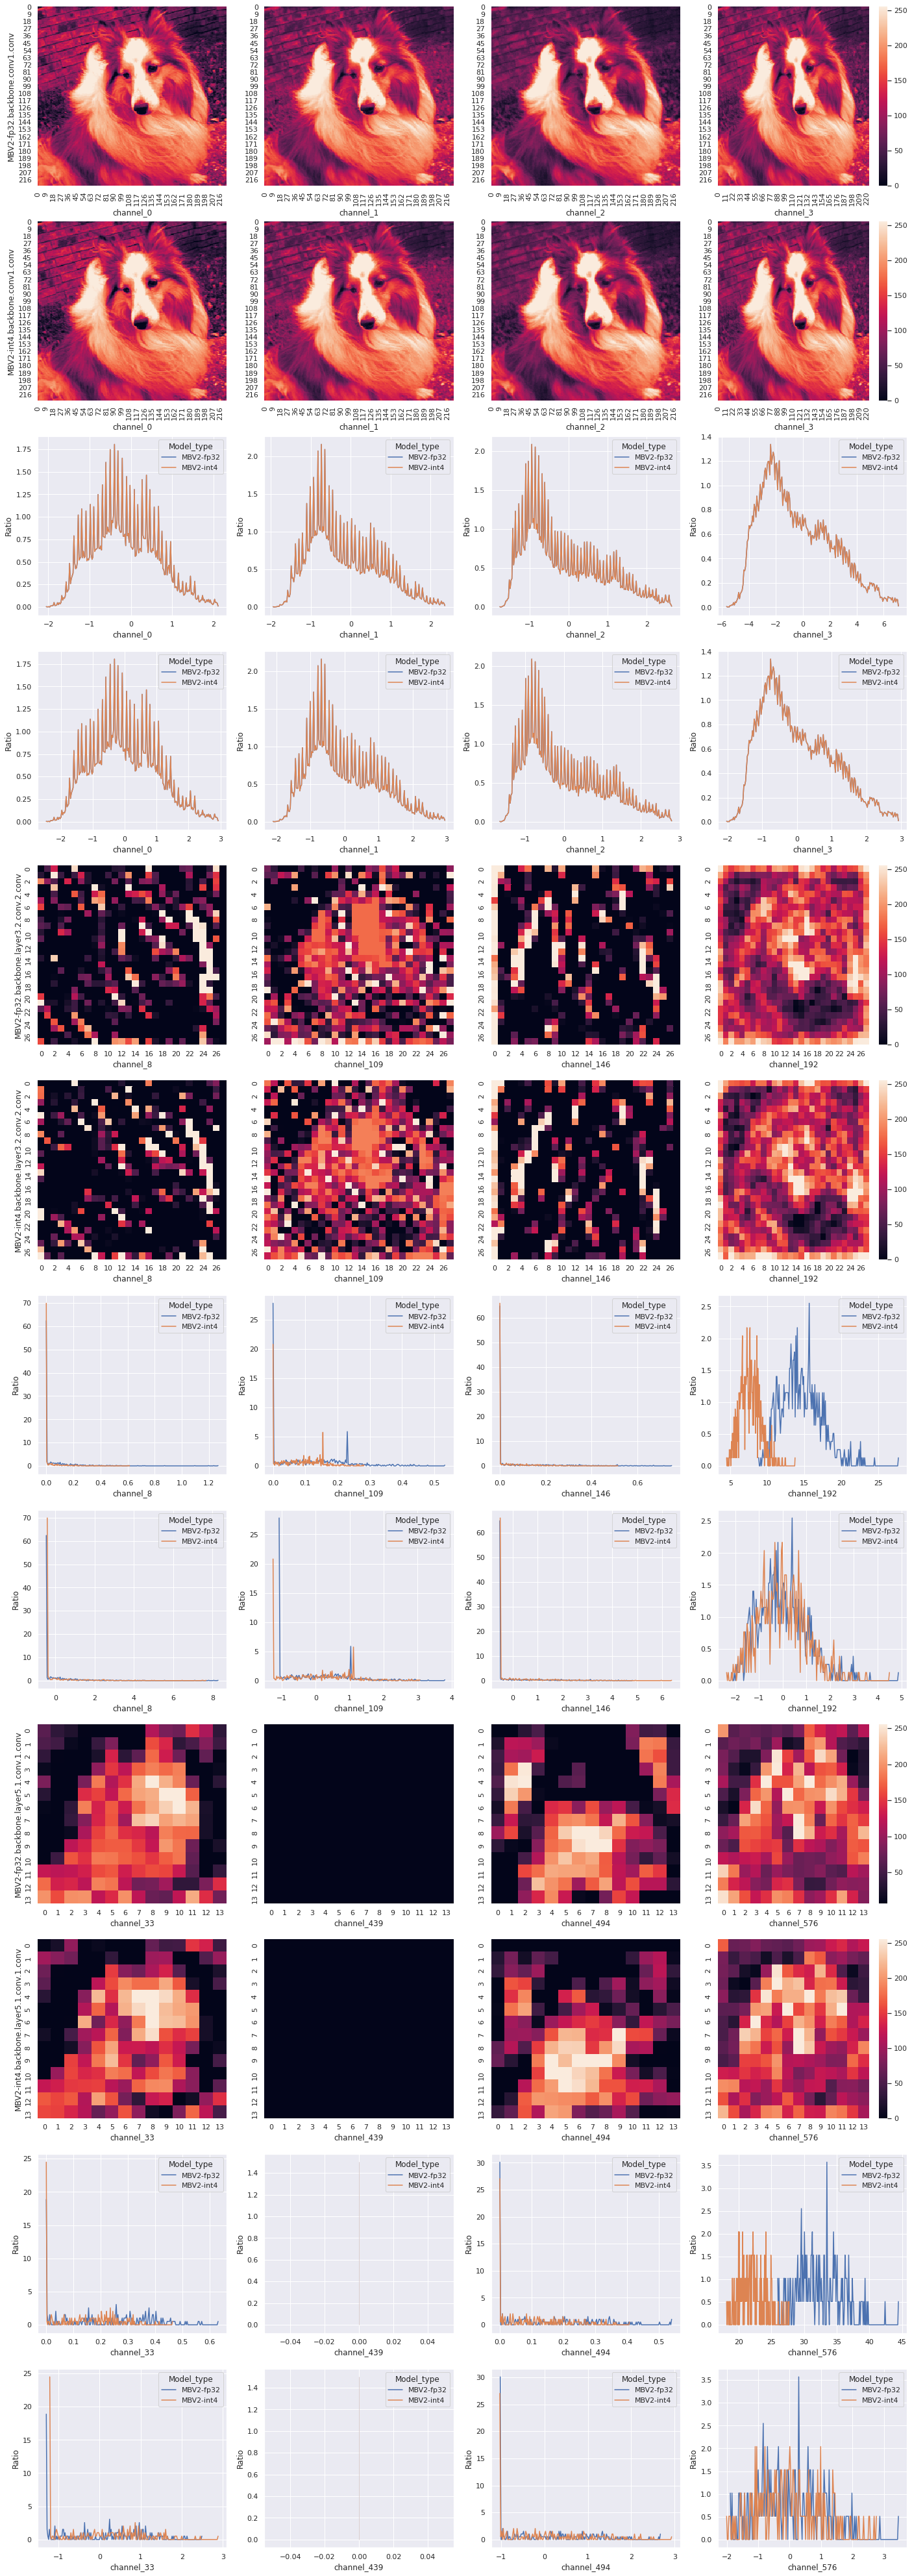

In [321]:
feat_visulizer = FeatureVisulizer(models, 
                                  extra_names = extra_names, 
                                  sample_num = 3,
                                  sample_channel = 4, 
                                  save_path= save_path)
feat_visulizer(inference_model, img = img)

In [283]:
print(feats.keys())
a = feats['MBV2-fp32.backbone.layer3.1.conv.1.conv']
b = feats['MBV2-int4.backbone.layer3.1.conv.1.conv']

odict_keys(['MBV2-fp32.backbone.conv1.conv', 'MBV2-int4.backbone.conv1.conv', 'MBV2-fp32.backbone.layer3.1.conv.1.conv', 'MBV2-int4.backbone.layer3.1.conv.1.conv', 'MBV2-fp32.backbone.layer4.2.conv.2.conv', 'MBV2-int4.backbone.layer4.2.conv.2.conv', 'MBV2-fp32.backbone.layer6.0.conv.0.conv', 'MBV2-int4.backbone.layer6.0.conv.0.conv'])


In [284]:
a2 = torch.sum(a, 1)
b2 = torch.sum(b,1)
(a2 - b2).abs().mean()

tensor(10.2181)

In [285]:
((a2 - a2.mean())/a2.std() - (b2 - b2.mean())/b2.std()).abs().mean()

tensor(0.4904)

In [286]:
bins = 600
y1 = a.histc(bins = bins)/a.numel()* 100
x1 = torch.linspace(a.min(), a.max(), steps = bins).to(device) 
y2 = b.histc(bins = bins)/a.numel()* 100
x2 = torch.linspace(b.min(), b.max(), steps = bins).to(device) 
#print(x1,'\n', x2)
#print(y1,'\n',y2)

x_sum = torch.cat((x1, x2))
y_sum = torch.cat((y1, y2))
model_type = np.concatenate((np.array(['MBV2-fp32' for _ in range(bins)]), 
                            np.array(['MBV2-int'  for _ in range(bins)])), axis=0)
layer_name = np.concatenate((np.array(['backbone.layer3.1.conv.1.conv' for _ in range(bins)]), 
                            np.array(['backbone.layer3.1.conv.1.conv'  for _ in range(bins)])), axis=0)

data = torch.stack((x_sum.t(), y_sum.t()),1).detach().float().cpu().numpy()
data = np.c_[ data, model_type.transpose(), layer_name] 

import pandas as pd
df = pd.DataFrame(data, columns = ['Value','Ratio', 'Model_type', 'Layer_name'])

df[['Value','Ratio', ]] = df[['Value','Ratio']].apply(pd.to_numeric)
df.astype(dtype = {'Model_type': 'string', 'Layer_name': 'string'})
type(df['Value'][0])

numpy.float64

In [287]:
df.head()

,Value,Ratio,Model_type,Layer_name
0,0.000000,33.366550,MBV2-fp32,backbone.layer3.1.conv.1.conv
1,0.002017,0.205942,MBV2-fp32,backbone.layer3.1.conv.1.conv
2,0.004034,0.214578,MBV2-fp32,backbone.layer3.1.conv.1.conv
3,0.006051,0.188005,MBV2-fp32,backbone.layer3.1.conv.1.conv
4,0.008068,0.191991,MBV2-fp32,backbone.layer3.1.conv.1.conv


<AxesSubplot:xlabel='Value', ylabel='Ratio'>

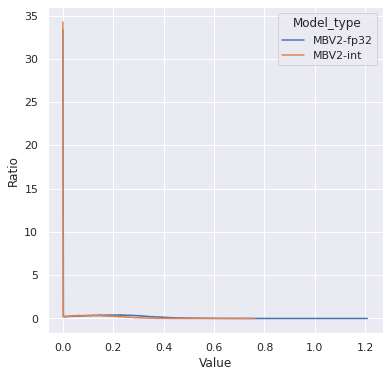

In [292]:
sns.set(style='darkgrid', rc={"figure.figsize": (6, 6)})
sns.lineplot(
    data=df, x="Value", y="Ratio", hue="Model_type", markers= '1', dashes=False)